# Fase 7 EDR

Los datos **no son una tabla agregada**. Si ves el archivo *summary* de test y train, es parte de las variables, y un csv. Ese csv contiene lo que parece ser una serie temporal con datos sobre el el estado del aterrizaje en cada instante de tiempo.

## EL PLAN
Necesitamos analizar las series temporales para sacar información sobre ellas, y agregarlas a los datos del excel para poder llevar a cabo una **regressión**.

#### Wind y turbulence
>https://www.gymlibrary.ml/environments/box2d/lunar_lander/#arguments

Son argumentos del AI gym que han enmascarado
Lo que haremos es primero entender cómo podemos analizar cada uno de los `experiments` y sacar atributos sobre ellos. Con eso, haremos <u>dos KNN inputer</u> para ambos wind y turbulence

## Origen de los datos (QUITAR AL ENTREGAR NO SEAMOS GILIPOLLAS)BOLUDOS
Donde se han simulado los datos:
>https://github.com/huggingface/deep-rl-class/tree/main/unit1/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from f7utils import *
from typing import List, TypeVar, NewType, Tuple

# Creaate the np array type without the nptyping library
NDArray = NewType("NDArray", np.ndarray)

Estructura de la carpeta:

In [2]:
!tree . -L 2 | head

.
├── data
│   ├── datos.zip
│   ├── experiments_summary_test.xlsx
│   ├── experiments_summary_train.xlsx
│   ├── metadata.txt
│   ├── test
│   └── train
├── f7utils.py
├── fase7.ipynb


## EDA
El EDA consisitirá de dos partes:
1. Ver como podemos sacar información valiosa sobre los experimentos
2. Ver como podemos agregar esa información a los xlsx

### Expermimentos
Veremos qué información útil podemos sacar de estas series temporales

#### Experimento 1
Exploraremos primero uno de los CSV

In [3]:
exp1 = pd.read_csv('data/train/experiment_1.csv')
exp1.tail()

,x_pos,y_pos,x_vel,y_vel,angle,ang_vel,leg_1,leg_2,main_booster,lat_booster
181,-0.019154,-0.000078,3.208921e-08,-8.263651e-10,0.010104,-9.295870e-08,1.0,1.0,-0.805837,0.085813
182,-0.019154,-0.000078,8.139656e-10,-1.154962e-09,0.010104,-9.564672e-09,1.0,1.0,-0.920978,0.154106
183,-0.019154,-0.000078,-2.477457e-08,-9.659399e-10,0.010104,6.116299e-08,1.0,1.0,-0.927008,-0.070478
184,-0.019154,-0.000078,-3.645077e-08,-6.210173e-10,0.010104,9.317984e-08,1.0,1.0,-0.671896,0.145986
185,-0.019154,-0.000078,0.000000e+00,0.000000e+00,0.010104,0.000000e+00,1.0,1.0,-0.671896,0.145986


In [4]:
print(f"El experimento 1 tiene {exp1.shape[0]} filas")

El experimento 1 tiene 186 filas


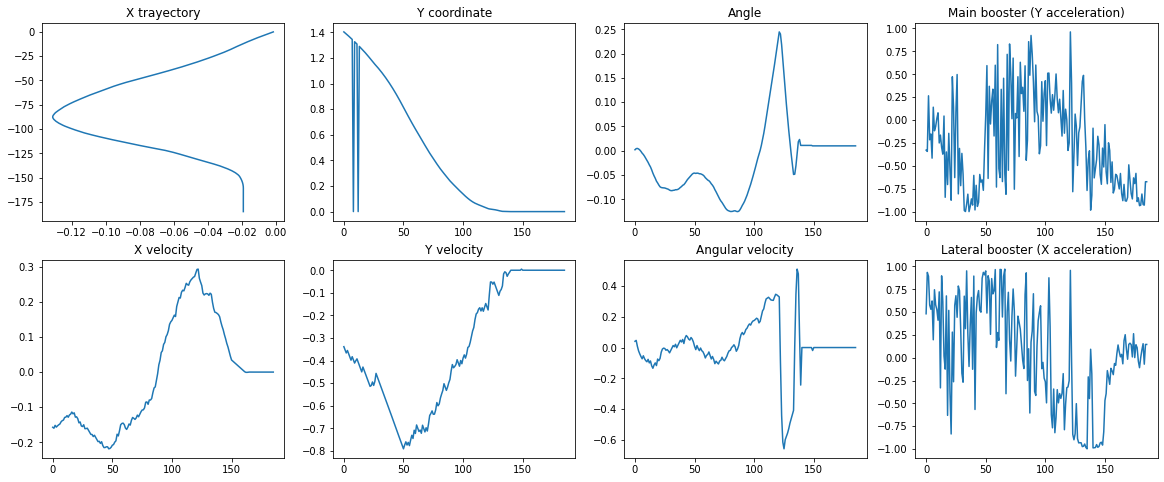

In [5]:
plotExperiment(exp1)

Suponemos que *leg_1* y *leg_2* solo valen 1 si está tocando el suelo

Aparentemente en el primer experimento la nave cae exageradamente dos veces. Esto probablemente se deba a errores de medida:

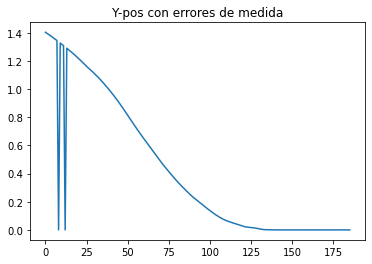

In [6]:
plt.plot(exp1.y_pos)
plt.title("Y-pos con errores de medida")
plt.show()

In [7]:
exp1.loc[exp1.y_pos == 0]

,x_pos,y_pos,x_vel,y_vel,angle,ang_vel,leg_1,leg_2,main_booster,lat_booster
8,-0.013675,0.0,-0.138264,-0.397028,-0.011219,-0.072471,0.0,0.0,-0.070441,0.579112
12,-0.019034,0.0,-0.124044,-0.406973,-0.028917,-0.099780,0.0,0.0,-0.163217,-0.330018


Nos hemos dado cuenta de que los dos puntos en los que la posición con respecto a __Y__ es igual a 0 se debe a malas lecturas. Si nos fijamos, las velocidades con respecto a ambos ejes y el resto de variables no han cambiado drásticamente como para alcanzar el suelo de golpe.

In [8]:
exp1["y_pos"][1]

1.3953845500946045

Así que lo que haremos es coger la anterior y siguiente medida de la posición $y$, y haremos la media de ambas para suavizar los errores.

In [9]:
exp1 = cleanZeroes(exp1, var="y_pos")

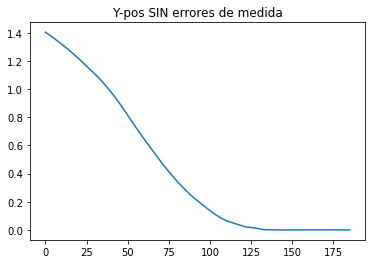

In [10]:
# plot y_pos again
plt.plot(exp1.y_pos)
plt.title("Y-pos SIN errores de medida")
plt.show()

### Experimento malo

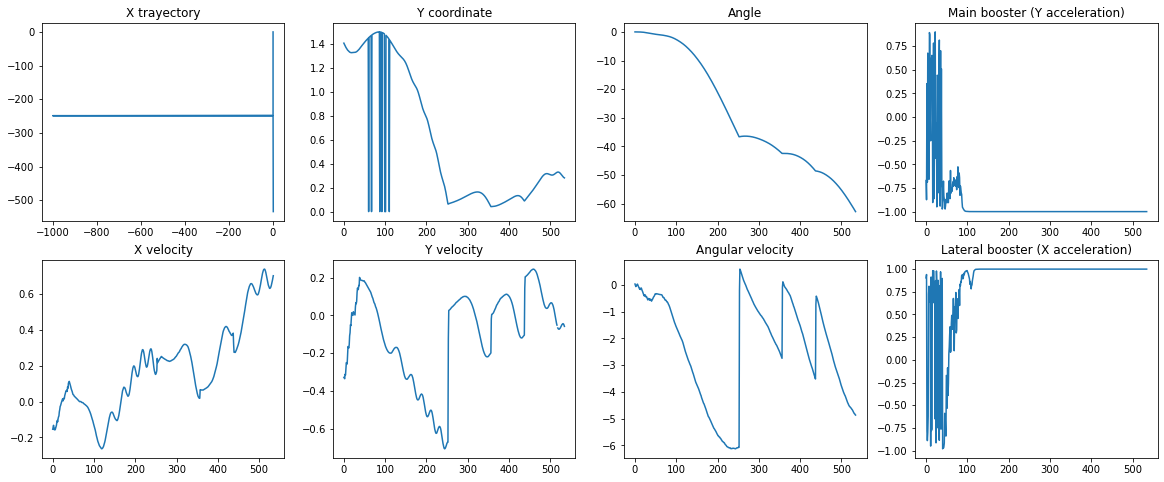

In [12]:
expbad = pd.read_csv('data/train/experiment_10010.csv')
plotExperiment(expbad)

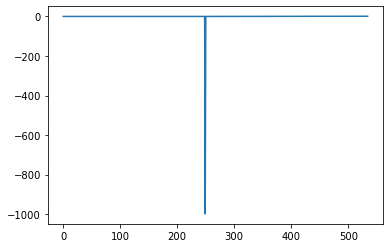

In [13]:
plt.plot(expbad.x_pos)